# Mô tả bài toán
Dự đoán giá của sản phẩm từ bộ dữ liệu được cung cấp sẵn

**Đầu vào:** Dữ liệu dạng văn bản và nhãn về tên, tình trạng, danh mục, nhãn hiệu, shipping và nhận xét của khách hàng về sản phẩm.   

**Đầu ra:** Giá dự đoán của sản phẩm. Kết quả này được Kaggle đánh giá theo công thức:   
\begin{align*}
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
\end{align*}
Trong đó:
* RMSLE là giá trị Root Mean Squared Logarithmic Error - độ đo được sử dụng trong Kaggle
* n là tổng số quan sát trong tập dữ liệu
* $p_i$ là giá dự đoán của sản phẩm i
* $a_i$ là giá trị thực của sản phẩm i
* log(x) là logarit tự nhiên của x

## **Tổng quan**   

Đây là dạng bài toán hồi quy. Mô tả mối quan hệ giữa biến kết quả (đầu ra - output, outcome) $y\in\mathbb R$ với các biến đầu vào (đặc trưng - input, features, predictors) $\mathbf x = x_1, x_2, \ldots x_d$ bằng một mô hình (hàm số) $y = f(x)$, khi biết tập dữ liệu $D = (\mathbf x_1, y_1), (\mathbf x_2, y_2),\ldots,(\mathbf x_n, y_n))$.   

Với dữ liệu đầu vào thuộc dạng văn bản (text) và nhãn (label), cần chuyển các đặc trưng về dạng số thực hoặc vector để đưa vào mô hình xử lý tuyến tính (hoặc mạng nơ ron, tuy nhiên bài làm chọn sử dụng mô hình tuyền tính, cụ thể về lí do chọn mô hình sẽ có ở các phần sau).   
* Sử dụng count vectorizer và tfidf vectorizer để xử lý dữ liệu dạng văn bản bằng cách vector hóa
* Sử dụng label binarizer để xử lý dữ liệu dạng nhãn bằng cách đặc trưng hóa

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math

from collections import Counter
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.linear_model import *
from sklearn.linear_model import Ridge
import xgboost as xgb

In [ ]:
# used for developing deep learning models
import torch
from torch.autograd import Variable
from torch import optim
#from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F

Nhập dữ liệu từ Kaggle và giải nén

In [ ]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z

In [ ]:
!unzip -n /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip -n /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

Các file csv gồm: train.vsv, test_stg2.tsv bao gồm dữ liệu để train, test (test_stg2.tsv là bộ dữ liệu test được thêm vào ở stage 2, sau khi cuộc thi đã kết thúc), và file submit mẫu sample_submission_stg2.csv.

Các file này sẽ tiếp tục được đọc vsử dụng pandas


In [ ]:
train = pd.read_csv('/kaggle/working/train.tsv', sep='\t')
test = pd.read_csv('/kaggle/working/test_stg2.tsv', sep='\t')

# Mô tả dữ liệu #

In [ ]:
train.info()
print('\n')
test.info()

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

Có thể thấy được category_name, brand_name và item_description là những trường có giá trị null ở cả hai tập train và test

In ra phân phối giá trị của dữ liệu để biết khoảng dữ liệu tập trung, khoảng dữ liệu còn rời rạc, thiếu sót

In [ ]:
train.describe()

In [ ]:
test.describe()

In ra các mục đầu của hai tập dữ liệu train và test để nhìn qua dữ liệu

In [ ]:
train.head()

In [ ]:
test.head()

Có thể thấy được một số giá trị trong trường brand_name có giá trị NaN là giá trị null. Điều này sẽ gây ra lỗi khi chuyển hóa dữ liệu dạng văn bản về vector.

Tập dữ liệu train có 1482535 sản phẩm, được đánh từ 0 đến 1482534   
Tập dữ liệu test có 3460725 sản phẩm, được đánh từ 0 đến 3460724   
Trong đó:   
Tập train gồm 8 trường (cột) dữ liệu, gồm train_id, name, item_condition_id, category_name, brand_name, price, shipping và item_description.    
Trong đó: 
train_id, item_condition_id, shipping có thuộc tính là int64   
name, category_name, brand_name, item_description có thuộc tính là object   
price có thuộc tính là float64

Tập test gồm 7 trường dữ liệu, trong đó tất cả đều giống các trường của tập train, ngoại trừ không có trường price là trường cần phải thực hiện dự đoán.   

Các trường category_name, brand_name, item_description có chứa giá trị null nên cần sử dụng các phương pháp fillnull để xử lý dữ liệu   

In [ ]:
train[train.price<0]

Không có sản phẩm nào có giá không hợp lệ (giá < 0$)

In [ ]:
print("There are %d unique values in the category column." % train['category_name'].nunique(), "\n")
# TOP 5 RAW CATEGORIES
print(train['category_name'].value_counts()[:5], "\n")
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

Có 1287 giá trị category_name trong cột category. Cột này có những giá trị danh mục gồm 3 trường con được ngăn cách bằng dấu "/"   
6327 sản phẩm không có nhãn trong category_name

In [ ]:
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)

# Chuẩn bị dữ liệu - Tiền xử lý   

Cột category_name có những giá trị danh mục gồm 3 trường con được ngăn cách bằng dấu "/"   

Có thể cắt thành các trường con tại dấu "/" để dễ dàng phân tích văn bản

In [ ]:
def split_cat(text):
    try: return text.split("/")
    except: return ("None", "None", "None")

In [ ]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))
test.head()

In [ ]:
print("There are %d unique first sub-categories." % train['general_cat'].nunique())
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

print("\nThere are %d unique brand names in the training dataset." % train['brand_name'].nunique())

Có lần lượt 11, 114 và 871 giá trị riêng trong trường các trường con của category_name sau khi được tách ra.   

Có 4810 giá trị riêng là các nhãn hiệu trong trường brand_name

Sau khi cắt mục category_name thành ba trường con, lập biểu đồ để xem xét sự phân phối đối với những sản phẩm đã có nhãn category_name

In [ ]:
### Plotting some histograms of categorical Variables
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
count_classes_general_cat = pd.value_counts(train.general_cat, sort = True)
count_classes_general_cat.plot(kind = 'bar')
plt.title("General Category histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
# subcategory 1
plt.subplot(3,3,3)
count_classes_subcat_1 = pd.value_counts(train.subcat_1, sort = True)[:15]
count_classes_subcat_1.plot(kind = 'bar')
plt.title("Sub Category 1 histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
# subcategory 2
plt.subplot(3,3,9)
count_classes_subcat_2 = pd.value_counts(train.subcat_2, sort = True)[:15]
count_classes_subcat_2.plot(kind = 'bar')
plt.title("Sub Category 2 histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

Các biểu đồ thể hiện số lần xuất hiện của các nhãn trong tập dữ liệu   
Trong đó:   
Woman là danh mục xuất hiện nhiều nhất trong trường con general_cat của category_name   
Athletic apparel và makeup là hai danh mục xuất hiện nhiều nhất trong trường con subcat_1 của category_name   
Pants, Tights, Leggings là danh mục xuất hiện nhiều nhất trong trường con subcat_2 của category_name   

Như đã phân tích ở trên: category_name, brand_name và item_description là những trường có giá trị null   
Có thể thay các giá trị null này bằng một dữ liệu dạng văn bản khác là 'None' và coi đó là một category_name, brand_name hay item_description

In [ ]:
#HANDLE MISSING VALUES - Replace null values with 'None'
print("Handling missing values...")
def handle_missing(dataset):
    #dataset.category_name.fillna(value="na", inplace=True)
    dataset.brand_name.fillna(value="None", inplace=True)
    dataset.item_description.fillna(value="None", inplace=True)
    dataset.category_name.fillna(value="None", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

train.isnull().sum()

Tiếp tục tìm hiểu dữ liệu trong các trường còn lại là item_condition_id và brand_name

In [ ]:
#Plotting item condition id
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
count_classes_item_condition_id = pd.value_counts(train.item_condition_id, sort = True)
count_classes_item_condition_id.plot(kind = 'bar')
plt.title("Item Condition histogram")
plt.xlabel("Item Condition")
plt.ylabel("Count")

#Plotting most common brand name
brand_count = Counter(list(train.brand_name.values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.title("Most common brand name histogram")
plt.ylabel("Brand")
plt.xlabel("Count")
plt.grid(False, axis='y')
plt.show()

Tình trạng của các mặt hàng đa số ở mức 1, và "None" xuất hiện nhiều nhất trong các nhãn hàng. Tức là số các mặt hàng không mang nhãn hiệu nào có nhiều nhất

In [ ]:
sns.distplot(train['price'], kde=True)

Qua biểu đồ phân phối giá sản phẩm, có thể thấy dữ liệu giá sản phẩm bị lệch khá nhiều, chủ yếu ở dưới 250$.   
   
**Giải pháp**: Hàm đồng biến log() sẽ đưa đồ thị giá về gần dạng phân bố chuẩn. Có thể đánh giá trên hàm log của price.

In [ ]:
sns.distplot(np.log1p(train['price']))

Phân bố của hàm log của price có dạng gần với phân phối chuẩn, nên có thể sử dụng để làm output dự đoán cho bài toán hồi quy.   
Có thể thêm một cột log_price để sử dụng làm output dự đoán.   

Theo lý thuyết, nếu phân bố dữ liệu $\mathcal P$ là phân bố chuẩn thì mô hình hồi quy tối ưu là mô hình tuyến tính

$$
f^\star(\mathbf x) = \mu_{y|\mathbf x} = w_1 x_1 +w_2 x_2 + \ldots w_d x_d + b = \mathbf w^T\mathbf x+b
$$

Điều này sẽ được sử dụng cho việc chọn mô hình huấn luyện ở phần kế tiếp

In [ ]:
train['log_price'] = np.log1p(train.price)
train.iloc[0] 

In [ ]:
train.head()

Có những từ ngữ, ký hiệu không mang nhiều ý nghĩa trong câu, có thể loại bỏ những từ ngữ, ký hiệu này, làm sạch dữ liệu để việc dự đoán đạt kết quả tốt hơn.   

Hàm clean_text sẽ loại bỏ các tag html, một số các ký tự, ký hiệu không liên quan và bỏ viết hoa chữ.   
Các ký tự được loại bỏ sẽ được thay bằng dấu cách


In [ ]:
def clean_text(text):
    """
    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["] using the resub method:
    text = re.sub(r'\\', '', text)

    text = re.sub(r'\"', '', text)   

    text = re.sub(r'\'', '', text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

clean_text("<html>What are y'all are a\" doing.<\html>")

In [ ]:
train.head()

# Đặc trưng hóa
Dựa vào số lượng mẫu của các đặc tính (unique number of each feature) ta chia dữ liệu thành 2 dạng để xử lý:

Biến đổi từ dạng văn bản về dạng vector số đối với: name, item_description.   
Phân loại theo các label đối với: item_condition_id, brand_name, shipping, general_cat, subcat_1, subcat_2.

**Vector hóa với dữ liệu dạng văn bản**    

Mô hình Bag of words: biểu diễn mỗi mẫu dữ liệu dưới dạng một vector số trong đó mỗi chiều là một từ cụ thể trong kho dữ liệu.   

Kho dữ liệu được khởi tạo khi gọi lệnh fit_transform từ tập train.   

Đối với tập test thì chỉ việc biểu diễn vector theo kho dữ liệu đã có (transform).   


Với dữ liệu dạng văn bản, để sử dụng làm input trong model dự đoán, văn bản cần được mã hóa dưới dạng số thực hoặc vector.   

Vì mỗi một chuỗi ở cột "name" khá ngắn nên sử dụng CountVectorizer() để chuyển cột name từ dạng văn bản về dạng một vector trên cơ sở số lần xuất hiện của mỗi từ (xuất hiện càng nhiều đánh giá càng cao). Những từ như and, a, the, ... (stopwords) là những từ không có ý nghĩa và xuất hiện nhiều khiến lu mờ các từ khác sẽ được loại bỏ với tùy chọn stop_words là english.

In [ ]:
count_vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=clean_text)

train_name = count_vectorizer.fit_transform(train['name'])
test_name = count_vectorizer.transform(test['name'])
pickle.dump(train_name, open("train_name.pickle", "wb"))
pickle.dump(test_name, open("test_name.pickle", "wb"))

# train_name = pickle.load(open(os.path.join('/kaggle/working/trained-sparse-matrix', 'train_name.pickle'), 'rb'))
# test_name = pickle.load(open(os.path.join('/kaggle/working/trained-sparse-matrix', 'test_name.pickle'), 'rb'))

In [ ]:
train_name.shape

Do số lượng từ ở cột item_description nhiều hơn, sẽ khó khăn hơn khi phân tích mục description vì đó là dữ liệu phi cấu trúc.   
* Mỗi loại sản phẩm có thể có từ ngữ thể hiển đặc điểm riêng của sản phẩm đó mà có thể quyết định giá của sản phẩm, còn một số từ ngữ xuất hiện nhiều có thể chưa chắc quyết định đến giá của sản phẩm nên chúng ta nên sử dụng mô hình TF-IDF để xử lý để chống việc các từ ngữ xuất hiện liên tục thường xuyên được đánh trọng số cao, còn những từ ngữ xuất hiện ít, quan trọng thì đánh trọng số thấp.   
* Với dữ liệu dạng văn bản là item_description, cần sử dụng thư viện vector hóa văn bản của sklearn là TfidfVectorizer.   

TF-IDF chuyển văn bản thành một vector mà trong đó, giá trị của từng phần tử đánh giá tầm quan trọng của một từ trong một văn bản.

Độ quan trọng được tính theo công thức:
$$i = log(\frac{n}{1 + n_{i}})$$
trong đó:

* $i$ : là số lần từ xuất hiện trong câu
* $n$ : là tổng số điểm dữ liệu
* $n_i$ : là số điểm dữ liệu có từ đó   

Ở đây, số điểm (đặc trưng) tối đa được chỉ định rõ là 500000. Nếu không, thời gian chạy của tf-idf vectorizer sẽ lâu hơn, mỗi vector sẽ có khoảng 1 triệu điểm.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 2),
                             max_features=500000)

train_des = tfidf_vectorizer.fit_transform(train['item_description'])
test_des = tfidf_vectorizer.transform(test['item_description'])
pickle.dump(train_des, open("train_des.pickle", "wb"))
pickle.dump(test_des, open("test_des.pickle", "wb"))

# train_des = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_des.pickle'), 'rb'))
# test_des = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_des.pickle'), 'rb'))

In [ ]:
train_des.shape

**Đặc trưng hóa phân loại theo nhãn**   

Với dữ liệu dạng nhãn (label), cần biến đổi các thuộc tính này thành một dạng số đại diện hơn để có thể dễ dàng đưa vào input của model. Ta sử dụng thư viện của sklearn là LabelBinarizer. Label Binarizer gom các label thành vector, trong đó giá trị của mỗi lable là 0 hoặc 1 thể hiện nó có xuất hiện hay không - hay biến đổi các nhãn nhiều lớp thành nhãn nhị phân.   

LabelBinarizer sẽ được sử dụng đối với các dữ liệu nhãn gồm brand_name, item_condition_id, shipping và category_name.    
Sau khi chuẩn hóa dữ liệu ở các cột category_name, sử dụng LabelBinarizer để chuyển đổi các nhãn nhiều lớp sang nhãn nhị phân ở các cột general_cat, subcat_1, subcat_2.

In [ ]:
lb_brand = LabelBinarizer(sparse_output=True)

train_brand = lb_brand.fit_transform(train['brand_name'])
test_brand = lb_brand.transform(test['brand_name'])
pickle.dump(train_brand, open("train_brand.pickle", "wb"))
pickle.dump(test_brand, open("test_brand.pickle", "wb"))

# train_brand = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_brand.pickle'), 'rb'))
# test_brand = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_brand.pickle'), 'rb'))

In [ ]:
train_brand.shape

In [ ]:
lb_condition_id = LabelBinarizer(sparse_output=True)

train_condition_id = lb_condition_id.fit_transform(train['item_condition_id'])
test_condition_id = lb_condition_id.transform(test['item_condition_id'])
pickle.dump(train_condition_id, open("train_condition_id.pickle", "wb"))
pickle.dump(test_condition_id, open("test_condition_id.pickle", "wb"))

# train_condition_id = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_condition_id.pickle'), 'rb'))
# test_condition_id = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_condition_id.pickle'), 'rb'))

In [ ]:
train_condition_id.shape

In [ ]:
lb_shipping = LabelBinarizer(sparse_output=True)

train_shipping = lb_shipping.fit_transform(train['shipping'])
test_shipping = lb_shipping.transform(test['shipping'])
pickle.dump(train_shipping, open("train_shipping.pickle", "wb"))
pickle.dump(test_shipping, open("test_shipping.pickle", "wb"))

# train_shipping = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_shipping.pickle'), 'rb'))
# test_shipping = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_shipping.pickle'), 'rb'))

In [ ]:
train_shipping.shape

In [ ]:
lb_general_cat = LabelBinarizer(sparse_output=True)

train_general_cat = lb_general_cat.fit_transform(train['general_cat'])
test_general_cat = lb_general_cat.transform(test['general_cat'])
pickle.dump(train_general_cat, open("train_general_cat.pickle", "wb"))
pickle.dump(test_general_cat, open("test_general_cat.pickle", "wb"))

# train_cat_top = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_cat_top.pickle'), 'rb'))
# test_cat_top = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_cat_top.pickle'), 'rb'))

In [ ]:
train_general_cat.shape

In [ ]:
lb_subcat_1 = LabelBinarizer(sparse_output=True)

train_subcat_1 = lb_subcat_1.fit_transform(train['subcat_1'])
test_subcat_1 = lb_subcat_1.transform(test['subcat_1'])
pickle.dump(train_subcat_1, open("train_subcat_1.pickle", "wb"))
pickle.dump(test_subcat_1, open("test_subcat_1.pickle", "wb"))

# train_cat_sub = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_cat_sub.pickle'), 'rb'))
# test_cat_sub = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_cat_sub.pickle'), 'rb'))

In [ ]:
train_subcat_1.shape

In [ ]:
lb_subcat_2 = LabelBinarizer(sparse_output=True)

train_subcat_2 = lb_subcat_2.fit_transform(train['subcat_2'])
test_subcat_2 = lb_subcat_2.transform(test['subcat_2'])
pickle.dump(train_subcat_2, open("train_subcat_2.pickle", "wb"))
pickle.dump(test_subcat_2, open("test_subcat_2.pickle", "wb"))

# train_cat_sub = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'train_cat_sub.pickle'), 'rb'))
# test_cat_sub = pickle.load(open(os.path.join('/kaggle/input/trained-sparse-matrix', 'test_cat_sub.pickle'), 'rb'))

In [ ]:
train_subcat_2.shape

## Gộp các đặc trưng sau khi vector hóa & đặc trưng hóa thành một ma trận   

Gom tất cả các mẫu dữ liệu và tham số đã xử lý thành một ma trận để có thể đưa vào mô hình train.   


In [ ]:
train_features = (train_name, train_des, train_brand,
                  train_condition_id, train_shipping, 
                  train_general_cat, train_subcat_1, train_subcat_2)

# X = hstack(train_features).tocsr()

test_features = (test_name, test_des, test_brand, 
                 test_condition_id, test_shipping,
                 test_general_cat,  test_subcat_1, test_subcat_2)

# test_features = hstack(test_features).tocsr()

**Sử dụng hàm lỗi RMSLE**

In [ ]:
#Hàm RMSLE của Kaggle
# https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate(y, y_pred):
    return rmsle(np.expm1(y), np.expm1(y_pred))

# Chọn và đánh giá mô hình

Do phân bố dữ liệu $\mathcal P$ của trường log_price (theo biểu đồ ở mục chuẩn bị dữ liệu) gần với phân bố chuẩn nên mô hình hồi quy tối ưu hơn sẽ là mô hình tuyến tính.    

Ngoài ra, việc chọn mô hình hồi quy tuyến tính còn có các lợi điểm sau

- Mối quan hệ trực tiếp giữa biến đầu ra $y$ và biến đầu vào $x_i$ thông qua hệ số $w_i$.
- Tính toán dễ dàng và nhanh
- Có cơ sở lý thuyết và thực hành tốt trong khoa học thống kê

**Cross validation** 

Để tránh hiện tượng Overfit, ta sử dụng kỹ thuật cross validation:   

Trích từ tập train data ra một tập con nhỏ (valid data set) và thực hiện việc đánh giá mô hình trên tập con nhỏ này.      
1. Ta chia tập train ra *k* tập con không có phần tử chung, có kích thước gần bằng nhau.
1. Tại mỗi lần kiểm thử, một trong số *k* tập con được lấy ra làm validata set.
1. Ở đây, để đánh giá độ hiệu quả của model, ta lấy 10% tập train làm tập valid.   
   
Sử dụng hàm hstack của scipy để nối các cột dữ liệu lại với nhau.   

In [ ]:
def run_model_train_predict(model, matrix_list):
#     X = matrix
#     X_train, X_test, y_train, y_test = train_test_split(X, train['price'], test_size=0.1)
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, train['log_price'], test_size=0.1, random_state=1)
    
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    return y_predict, y_test

Do bài toán là dạng hồi quy nên sử dụng một số mô hình tuyến tính điển hình mà thư viện sklearn hỗ trợ.

Các model được chọn để chạy với tập con nhằm đánh giá gồm: Ridge Regression, SGDRegressor, XGBoost

Vì bộ nhớ có hạn, không thể chạy tất cả model trong cùng một notebook; vì vậy cần phải chạy riêng từng model một và lưu lại kết quả.

### Ridge Regression ###
Regularization cơ bản là thay đổi mô hình một chút để tránh overfitting trong khi vẫn giữ được tính tổng quát của nó (tính tổng quát là tính mô tả được nhiều dữ liệu, trong cả tập training và test).Ta sẽ tìm cách di chuyển nghiệm của bài toán tối ưu hàm mất mát tới một điểm gần nó. Hướng di chuyển sẽ là hướng làm cho mô hình ít phức tạp hơn mặc dù giá trị của hàm mất mát có tăng lên một chút.   

Kỹ thuật regularization phổ biến nhất là thêm vào hàm mất mát một số hạng nữa. Số hạng này thường dùng để đánh giá độ phức tạp của mô hình. Số hạng này càng lớn, thì mô hình càng phức tạp.   

* Hồi quy Ridge (Ridge Regression) là một kỹ thuật để phân tích nhiều dữ liệu hồi quy chịu sự đa hình. Khi đa cộng tuyến xảy ra, ước tính bình phương tối thiểu là không thiên vị, nhưng phương sai của chúng lớn nên chúng có thể cách xa giá trị thực. Bằng cách thêm một mức độ sai lệch cho các ước tính hồi quy, hồi quy sườn giúp giảm các lỗi tiêu chuẩn.

* Ridge Regression là mô hình hồi quy phân tích mối quan hệ giữa các biến độc lập và các biến phụ thuộc sử dụng phương pháp Regularization, điều chình mô hình sao cho giảm thiểu các vấn đề Overfitting, tối ưu hay kiểm soát mức độ phức tạp của mô hình để cân đối giữa Biased và Variance, qua đó giảm sai số của mô hình.

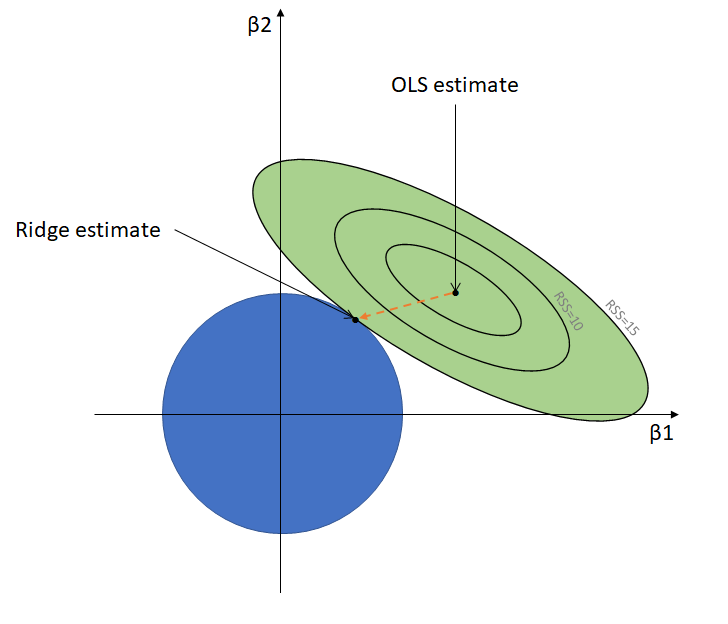

Linear Regression với l2 regularization được gọi là Ridge Regression. Trong đó, λ là số hạng regularization, thường là một số dương nhỏ để giảm độ phức tạp của mô hình và không làm giảm chất lượng nghiệm so với Linear Regression. Hàm mất mát của Ridge có dạng:   

\begin{align*} 
L(w) = \frac{1}{2} \left \| y - Xw \right \|_{2}^{2} + \lambda \left \| w \right \|_{2}^{2}
\end{align*}
   
Các hệ số theo Ridge sẽ nhỏ hơn đáng kể so với OLS, dẫn đến đa phần training score sẽ thấp hơn nhưng điểm test thực tế lại cao hơn (so với linear regression truyền thống). Vì Ridge đã loại bớt được số lượng các hệ số, giảm bớt độ phức tạp của mô hình, qua đó tránh được tình trạng overfitting, đạt được genelization với dữ liệu test.

In [ ]:
#Ridge train
ridge = Ridge()
ridge_predict, y_test = run_model_train_predict(model=ridge, matrix_list=train_features)

## Evaluate with RSMLE
ridge_result = evaluate(y_test, ridge_predict)
print("RMSLE: " + str(ridge_result))

### SGD Regression ###
Với default loss='squared_loss', model đang sử dụng là Linear Regression truyền thống với thuật toán tối ưu hàm mất mát Stochastic Gradient Descent.   

Việc tìm global minimum của hàm mất mát gần như bất khả thi. Thay vào đó ta tìm điểm local minimum có giá trị chấp nhận được rồi coi đó là kết quả của bài toán. Hướng tiếp cận ta đề cập đến là Gradient Descent: xuất phát từ một điểm mà chúng ta coi là gần với nghiệm của bài toán, sau đó dùng một phép toán lặp để tiến dần đến điểm cần tìm, tức đến khi đạo hàm gần với 0.   

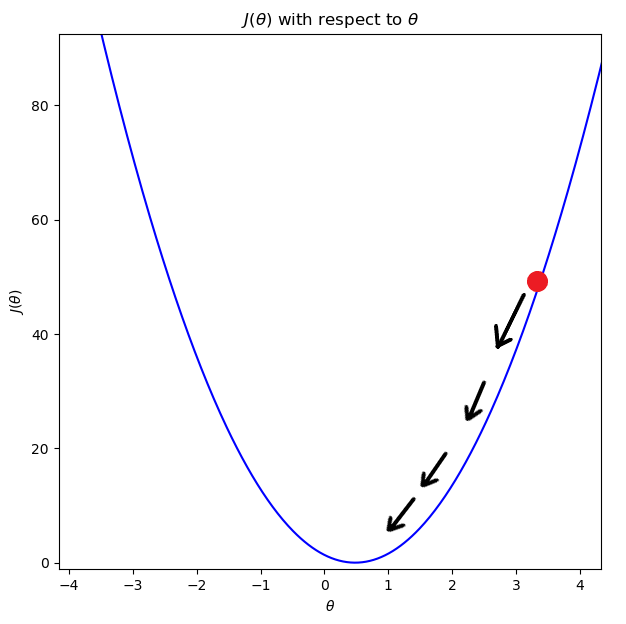   
Stochastic Gradient Descent   

Thay vì tính đạo hàm hàm loss trên toàn bộ tập dữ liệu rồi mới cập nhật w, giờ đây ta cập nhật trên mỗi điểm dữ liệu. Việc cập nhật từng điểm một như thế này có thể làm giảm đi tốc độ thực hiện 1 epoch (một lần duyệt qua toàn bộ các điểm trên tập dữ liệu). Nhưng mặt khác, SGD chỉ yêu cầu một lượng epoch rất nhỏ. Vì vậy SGD phù hợp với các bài toán có lượng data lớn.

In [ ]:
#SGD train
sgd = SGDRegressor()
sgd_predict, y_test = run_model_train_predict(model=sgd, matrix_list=train_features)

## Evaluate with RSMLE
sgd_result = evaluate(y_test, sgd_predict)
print("RMSLE: " + str(sgd_result))

### XGBoost ###
XGBoost tối ưu các tài nguyên tính toán bằng cách xây dựng các cây Decision Tree một cách song song cùng các thuật toán tối ưu khác.

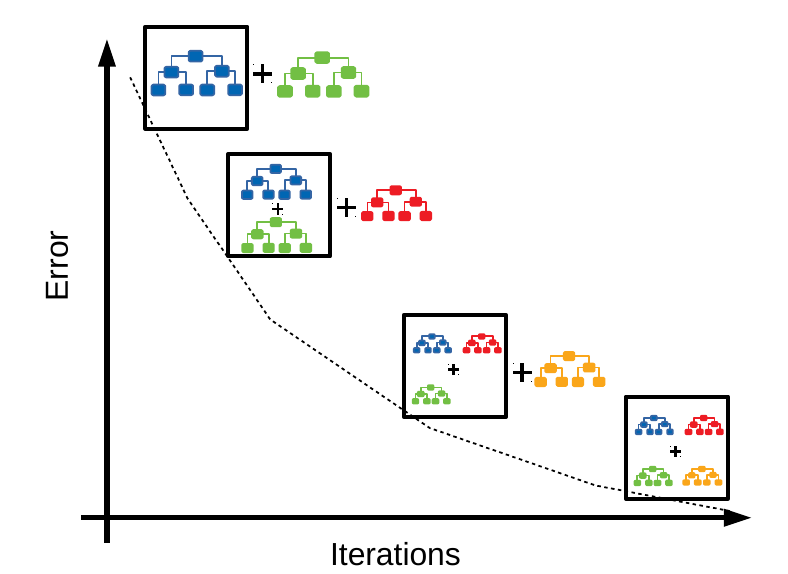

Ưu điểm của XGBoost:

* Tốc độ xử lý - XGBoost thực hiện tinh toán song song nên tốc độ xử lý có thể tăng gấp 10 lần so với GBM. Ngoài ra, XGboost còn hỗ trợ tính toán trên Hadoop.
* Overfitting - XGBoost áp dụng cơ chế Regularization nên hạn chế đáng kể hiện tượng Overfitting (GBM không có regularization).
* Sự linh hoạt - XGboost cho phép người dùng sử dụng hàm tối ưu và chỉ tiêu đánh giá của riêng họ, không hạn chế ở những hàm cung cấp sẵn.
* Xử lý missing value - XGBoost bao gồm cơ chế tự động xử lý missing value bên trong nó. Vì thế, có thể bỏ qua bước này khi chuẩn bị dữ liệu cho XGBoost.
* Tự động cắt tỉa - Tính năng tree pruning hỗ trợ việc tự động bỏ qua những leaves, nodes không mang giá trị tích cực trong quá trình mở rộng tree.

XGBoost được đánh giá vô cùng mạnh mẽ khi có thể giải quyết các bài toán phi tuyến tính cùng các kỹ thuật như regularization để giảm overfiting dữ liệu.

Nhưng bên cạnh đó, XGBoost nói riêng và các thuật toán tree-based nói chung vẫn không tránh khỏi một vài hạn chế, đặc biệt là trong việc giải quyết bài toán xử lý ngôn ngữ.

In [ ]:
# XGBoost train
xgboost = xgb.XGBRegressor(random_state=0)
xgboost_predict, y_test = run_model_train_predict(model=xgboost, matrix_list=train_features)

## Evaluate with RSMLE
xgboost_result = evaluate(y_test, xgboost_predict)
print("RMSLE: " + str(xgboost_result))

### Chọn mô hình huấn luyện ###
Như vậy, model tuyến tính Ridge cho kết quả khá tốt, hai mô hình Boosting cho kết quả không quá cao hơn so với mô hình tuyến tính.   

Dựa trên kết quả RMSLE, mô hình Ridge Regression sẽ được chọn để huấn luyện

In [ ]:
def main(model, sparse_matrix_list_train, sparse_matrix_list_test):

    X_train = hstack(sparse_matrix_list_train).tocsr()

    y_train = train['log_price']

    model.fit(X_train, y_train)
    
    X_test = hstack(sparse_matrix_list_test).tocsr()

    predicts = model.predict(X_test)
    
    return predicts

In [ ]:
ridge = Ridge()
main_predict = main(model=ridge, sparse_matrix_list_train=train_features, sparse_matrix_list_test=test_features)
main_predict

In [ ]:
main_predict.shape

Sau khi chạy mô hình, kết quả trả về là một mảng các giá trị là giá dự đoán của những sản phẩm trong tập test

# Submit lên Kaggle

Đọc file mẫu sample_submission

In [ ]:
submission = pd.read_csv('sample_submission_stg2.csv')
submission

Thay price trong submit mẫu bằng price đã dự đoán:

In [ ]:
submission.loc[:, 'price'] = np.expm1(main_predict)
submission

Xuất file submission.csv để submit:

In [ ]:
submission.to_csv('submission.csv', index=False)